## Решение задачи booster-tinkoff

2017, Александр Дьяконов

https://alexanderdyakonov.wordpress.com/

In [ ]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np


# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

### загрузка данных

In [2]:
train = pd.read_csv('merchants_train.csv', encoding='cp1251', sep=';', decimal='.')
test = pd.read_csv('merchants_test.csv', encoding='cp1251', sep=';', decimal='.')
transactions = pd.read_csv('transactions.csv', encoding='cp1251', sep=';', decimal='.')

print (train.shape, test.shape, transactions.shape)

(6482, 3) (3524, 3) (249353, 5)


In [3]:
transactions.transaction_time = pd.to_datetime(transactions.transaction_time)
transactions.record_time = pd.to_datetime(transactions.record_time)


def myrep(x):
    x = x.replace(u'май', '05')
    x = x.replace(u'дек', '12')
    x = x.replace(u'июн', '06')
    x = x.replace(u'апр', '04')
    x = x.replace(u'фев', '02')
    x = x.replace(u'мар', '03')
    return (x)

transactions.longitude = transactions.longitude.apply(lambda x: myrep(x)).astype(float)
transactions.latitude = transactions.latitude.apply(lambda x: myrep(x)).astype(float)

transactions['fd'] = transactions.latitude.astype(str) + ' ' + transactions.longitude.astype(str)
tmp = transactions.groupby('fd')['merchant_id']
transactions['n_merchants'] = transactions.fd.map(tmp.nunique())
transactions['n_latlong'] = transactions.fd.map(tmp.count())
transactions['n_merchants_by_n_latlong'] = transactions['n_merchants'] / transactions['n_latlong']

transactions['delta'] = transactions.transaction_time - transactions.record_time
transactions['h1'] = transactions.transaction_time.dt.hour
transactions['m1'] = transactions.transaction_time.dt.minute
transactions['s1'] = transactions.transaction_time.dt.second
transactions['h2'] = transactions.record_time.dt.hour
transactions['m2'] = transactions.record_time.dt.minute
transactions['s2'] = transactions.record_time.dt.second

transactions.transaction_time = transactions.transaction_time - pd.to_datetime('2017-01-28T00:00:00.000000000')
transactions.record_time = transactions.record_time - pd.to_datetime('2017-01-28T00:00:00.000000000')

transactions.delta = transactions.delta.dt.total_seconds()
transactions.transaction_time = transactions.transaction_time.dt.total_seconds()
transactions.record_time = transactions.record_time.dt.total_seconds()

transactions['fd2'] = transactions.latitude.astype(str) + ' ' + transactions.longitude.astype(str) + ' ' + transactions.merchant_id.astype(str)

tmp = transactions.groupby('fd2')['merchant_id']
transactions['n_in_merch'] = transactions.fd2.map(tmp.count())

transactions['order_in_merch'] = np.arange(transactions.shape[0])
tmp = transactions['merchant_id'].map(transactions.groupby('merchant_id').order_in_merch.min())
transactions['order_in_merch'] = transactions['order_in_merch'] - tmp

transactions['points_in_merch'] = transactions['merchant_id'].map(transactions.groupby('merchant_id').order_in_merch.count())
transactions['per_order_in_merch'] = transactions['order_in_merch'] / (transactions['points_in_merch'] - 1)


#tmp = transactions.groupby('merchant_id')['merchant_id']
#transactions['points_in_merch'] = transactions.merchant_id.map(tmp.count())

transactions['max_in_merch'] = transactions.merchant_id.map(transactions.groupby('merchant_id')['n_in_merch'].max())
transactions['n_by_max_in_merch'] = transactions['n_in_merch'] / transactions['max_in_merch']
transactions['n_by_points_in_merch'] = transactions['n_in_merch'] / transactions['points_in_merch']

transactions[:10]

,merchant_id,latitude,longitude,transaction_time,record_time,fd,n_merchants,n_latlong,n_merchants_by_n_latlong,delta,h1,m1,s1,h2,m2,s2,fd2,n_in_merch,order_in_merch,points_in_merch,per_order_in_merch,max_in_merch,n_by_max_in_merch,n_by_points_in_merch
0,178,0.000000,0.000000,552887.0,552636.0,0.0 0.0,5195,25018,0.20765,251.0,9,34,47,9,30,36,0.0 0.0 178,4,0,8,0.000000,4,1.0,0.500000
1,178,55.055996,82.912991,582590.0,582864.0,55.0559955 82.912991,1,2,0.50000,-274.0,17,49,50,17,54,24,55.0559955 82.912991 178,2,1,8,0.142857,4,0.5,0.250000
2,178,0.000000,0.000000,552887.0,552682.0,0.0 0.0,5195,25018,0.20765,205.0,9,34,47,9,31,22,0.0 0.0 178,4,2,8,0.285714,4,1.0,0.500000
3,178,55.056034,82.912734,582590.0,582181.0,55.0560344 82.9127341,1,2,0.50000,409.0,17,49,50,17,43,1,55.0560344 82.9127341 178,2,3,8,0.428571,4,0.5,0.250000
4,178,55.056034,82.912734,582590.0,582317.0,55.0560344 82.9127341,1,2,0.50000,273.0,17,49,50,17,45,17,55.0560344 82.9127341 178,2,4,8,0.571429,4,0.5,0.250000
5,178,0.000000,0.000000,555910.0,556196.0,0.0 0.0,5195,25018,0.20765,-286.0,10,25,10,10,29,56,0.0 0.0 178,4,5,8,0.714286,4,1.0,0.500000
6,178,0.000000,0.000000,568133.0,568074.0,0.0 0.0,5195,25018,0.20765,59.0,13,48,53,13,47,54,0.0 0.0 178,4,6,8,0.857143,4,1.0,0.500000
7,178,55.055996,82.912991,582590.0,582694.0,55.0559955 82.912991,1,2,0.50000,-104.0,17,49,50,17,51,34,55.0559955 82.912991 178,2,7,8,1.000000,4,0.5,0.250000
8,267,55.741642,37.502628,574468.0,574371.0,55.74164165 37.50262834,4,10,0.40000,97.0,15,34,28,15,32,51,55.74164165 37.50262834 267,2,0,13,0.000000,2,1.0,0.153846
9,267,55.707007,37.582190,603750.0,603394.0,55.70700729 37.58219037,1,2,0.50000,356.0,23,42,30,23,36,34,55.70700729 37.58219037 267,2,1,13,0.083333,2,1.0,0.153846


### формирование признакового пространства 

In [ ]:
# попадание в дельта-окрестность
def deltadistpoint3(xx, yy, xx2, yy2, w, delta=0.002): # 0.01
    x1, x2 = np.meshgrid(xx, xx2)
    y1, y2 = np.meshgrid(yy, yy2)
    h0 = 1 / ((x1 - x2) ** 2 + (y1 - y2) ** 2 + delta + 1.0)
    h = (np.abs(x1 - x2) <= delta) & (np.abs(y1 - y2) <= delta)
    h = h + h0
    #hsum = h.sum(0)
    hsum = np.dot(w, h)
    t = np.argmax(hsum)
    return (t, hsum)

d1=0.002
d2=0.005

for user in transactions.merchant_id.unique():
    
    tmp = transactions[transactions.merchant_id == user]
    
    x2 = tmp.latitude.values
    y2 = tmp.longitude.values
    x1 = tmp.latitude.values
    y1 = tmp.longitude.values
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d1)
    transactions.loc[transactions.merchant_id == user, 'a1'] = h
    transactions.loc[transactions.merchant_id == user, 'a1_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'a1_sum'] = h / h.sum()
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d2)
    transactions.loc[transactions.merchant_id == user, 'a2'] = h
    transactions.loc[transactions.merchant_id == user, 'a2_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'a2_sum'] = h / h.sum()    
    
    w = x2*0 + 0.99*(tmp.n_merchants.astype(float).values <= 1) + 0.01
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d1)
    transactions.loc[transactions.merchant_id == user, 'aw1'] = h
    transactions.loc[transactions.merchant_id == user, 'aw1_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'aw1_sum'] = h / h.sum()
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d2)
    transactions.loc[transactions.merchant_id == user, 'aw2'] = h
    transactions.loc[transactions.merchant_id == user, 'aw2_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'aw2_sum'] = h / h.sum()     
    
    
    tmp = tmp.drop_duplicates('fd')
    
    x2 = tmp.latitude.values
    y2 = tmp.longitude.values    
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d1)
    transactions.loc[transactions.merchant_id == user, 'a3'] = h
    transactions.loc[transactions.merchant_id == user, 'a3_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'a3_sum'] = h / h.sum()
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d2)
    transactions.loc[transactions.merchant_id == user, 'a4'] = h
    transactions.loc[transactions.merchant_id == user, 'a4_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'a4_sum'] = h / h.sum()
    
    w = x2*0 + 0.99*(tmp.n_merchants.astype(float).values <=1) + 0.01
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d1)
    transactions.loc[transactions.merchant_id == user, 'aw3'] = h
    transactions.loc[transactions.merchant_id == user, 'aw3_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'aw3_sum'] = h / h.sum()
    
    _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d2)
    transactions.loc[transactions.merchant_id == user, 'aw4'] = h
    transactions.loc[transactions.merchant_id == user, 'aw4_max'] = h / h.max()
    transactions.loc[transactions.merchant_id == user, 'aw4_sum'] = h / h.sum()     
    
    tmp = tmp[(tmp.latitude.values > 0.1) & (tmp.longitude.values > 0.1)]
    
    if (tmp.shape[0] > 0):
        
        x2 = tmp.latitude.values
        y2 = tmp.longitude.values    

        _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d1)
        transactions.loc[transactions.merchant_id == user, 'a5'] = h
        transactions.loc[transactions.merchant_id == user, 'a5_max'] = h / h.max()
        transactions.loc[transactions.merchant_id == user, 'a5_sum'] = h / h.sum()

        _ , h = deltadistpoint3(x1, y1, x2, y2, x2*0 + 1.0, delta=d2)
        transactions.loc[transactions.merchant_id == user, 'a6'] = h
        transactions.loc[transactions.merchant_id == user, 'a6_max'] = h / h.max()
        transactions.loc[transactions.merchant_id == user, 'a6_sum'] = h / h.sum()
        
        w = x2*0 + 0.99*(tmp.n_merchants.astype(float).values <=1) + 0.01

        _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d1)
        transactions.loc[transactions.merchant_id == user, 'aw5'] = h
        transactions.loc[transactions.merchant_id == user, 'aw5_max'] = h / h.max()
        transactions.loc[transactions.merchant_id == user, 'aw5_sum'] = h / h.sum()

        _ , h = deltadistpoint3(x1, y1, x2, y2, w, delta=d2)
        transactions.loc[transactions.merchant_id == user, 'aw6'] = h
        transactions.loc[transactions.merchant_id == user, 'aw6_max'] = h / h.max()
        transactions.loc[transactions.merchant_id == user, 'aw6_sum'] = h / h.sum()          
    
    else:
        transactions.loc[transactions.merchant_id == user, 'a5'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'a5_max'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'a5_sum'] = 0.0

        transactions.loc[transactions.merchant_id == user, 'a6'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'a6_max'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'a6_sum'] = 0.0
        
        transactions.loc[transactions.merchant_id == user, 'aw5'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'aw5_max'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'aw5_sum'] = 0.0

        transactions.loc[transactions.merchant_id == user, 'aw6'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'aw6_max'] = 0.0
        transactions.loc[transactions.merchant_id == user, 'aw6_sum'] = 0.0 

In [109]:




# ЦЕЛЕВОЙ ВЕКТОР!

ids = train.merchant_id.values.tolist() # del

X = transactions[transactions.merchant_id.isin(ids)]
X['right_lat'] = X.merchant_id.map(dict(zip(train.merchant_id.values, train.latitude)))
X['right_long'] = X.merchant_id.map(dict(zip(train.merchant_id.values, train.longitude)))
#X['goal'] = 0.0 + ((np.abs(X.latitude - X.right_lat) <= 0.002) & (np.abs(X.longitude - X.right_long) <= 0.002))
X['goal'] = 0.0 + ((np.abs(X.latitude - X.right_lat) <= 0.001) & (np.abs(X.longitude - X.right_long) <= 0.001))
# ИЗМЕНИТЬ


X = X[[ 'merchant_id', 'latitude', 'longitude', 'transaction_time',
       'record_time', 'n_merchants', 'n_latlong',
       'n_merchants_by_n_latlong', 'delta', 'h1', 'm1', 's1', 'h2', 'm2', 's2',
        'n_in_merch', 'points_in_merch', 'order_in_merch', 'per_order_in_merch', 'max_in_merch',
       'n_by_max_in_merch', 'n_by_points_in_merch', 'a1', 'a1_max', 'a1_sum',
       'a2', 'a2_max', 'a2_sum', 'a3', 'a3_max', 'a3_sum', 'a4', 'a4_max',
       'a4_sum', 'a5', 'a5_max', 'a5_sum', 'a6', 'a6_max', 'a6_sum', 'aw1', 'aw1_max', 'aw1_sum',
       'aw2', 'aw2_max', 'aw2_sum', 'aw3', 'aw3_max', 'aw3_sum', 'aw4', 'aw4_max',
       'aw4_sum', 'aw5', 'aw5_max', 'aw5_sum', 'aw6', 'aw6_max', 'aw6_sum', 'goal']]

y = X.goal.values
del X['goal']

print (X.shape, y.shape)
X[:5]

(166912, 58) (166912,)


,merchant_id,latitude,longitude,transaction_time,record_time,n_merchants,n_latlong,n_merchants_by_n_latlong,delta,h1,m1,s1,h2,m2,s2,n_in_merch,points_in_merch,order_in_merch,per_order_in_merch,max_in_merch,n_by_max_in_merch,n_by_points_in_merch,a1,a1_max,a1_sum,a2,a2_max,a2_sum,a3,a3_max,a3_sum,a4,a4_max,a4_sum,a5,a5_max,a5_sum,a6,a6_max,a6_sum,aw1,aw1_max,aw1_sum,aw2,aw2_max,aw2_sum,aw3,aw3_max,aw3_sum,aw4,aw4_max,aw4_sum,aw5,aw5_max,aw5_sum,aw6,aw6_max,aw6_sum
0,178,0.000000,0.000000,552887.0,552636.0,5195,25018,0.20765,251.0,9,34,47,9,30,36,4,8,0,0.000000,4,1.0,0.50,7.99242,1.0,0.125,7.980503,1.0,0.125,1.998206,0.500038,0.083338,1.995227,0.500038,0.083338,0.000202,0.000051,0.000013,0.000202,0.000051,0.000013,0.080324,0.010051,0.002488,0.080205,0.010051,0.002488,0.020182,0.005051,0.001256,0.020152,0.005051,0.001256,0.000202,0.000051,0.000013,0.000202,0.000051,0.000013
1,178,55.055996,82.912991,582590.0,582864.0,1,2,0.50000,-274.0,17,49,50,17,54,24,2,8,1,0.142857,4,0.5,0.25,7.99242,1.0,0.125,7.980503,1.0,0.125,3.996109,1.000000,0.166662,3.990151,1.000000,0.166662,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987,7.992020,1.000000,0.247512,7.980103,1.000000,0.247512,3.996009,1.000000,0.248744,3.990051,1.000000,0.248744,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987
2,178,0.000000,0.000000,552887.0,552682.0,5195,25018,0.20765,205.0,9,34,47,9,31,22,4,8,2,0.285714,4,1.0,0.50,7.99242,1.0,0.125,7.980503,1.0,0.125,1.998206,0.500038,0.083338,1.995227,0.500038,0.083338,0.000202,0.000051,0.000013,0.000202,0.000051,0.000013,0.080324,0.010051,0.002488,0.080205,0.010051,0.002488,0.020182,0.005051,0.001256,0.020152,0.005051,0.001256,0.000202,0.000051,0.000013,0.000202,0.000051,0.000013
3,178,55.056034,82.912734,582590.0,582181.0,1,2,0.50000,409.0,17,49,50,17,43,1,2,8,3,0.428571,4,0.5,0.25,7.99242,1.0,0.125,7.980503,1.0,0.125,3.996109,1.000000,0.166662,3.990151,1.000000,0.166662,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987,7.992020,1.000000,0.247512,7.980103,1.000000,0.247512,3.996009,1.000000,0.248744,3.990051,1.000000,0.248744,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987
4,178,55.056034,82.912734,582590.0,582317.0,1,2,0.50000,273.0,17,49,50,17,45,17,2,8,4,0.571429,4,0.5,0.25,7.99242,1.0,0.125,7.980503,1.0,0.125,3.996109,1.000000,0.166662,3.990151,1.000000,0.166662,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987,7.992020,1.000000,0.247512,7.980103,1.000000,0.247512,3.996009,1.000000,0.248744,3.990051,1.000000,0.248744,3.996008,1.000000,0.249987,3.990050,1.000000,0.249987


In [111]:
# что действительно - работает
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from time import time
# import xgboost as xgb

def myerror(train, a):
    i = np.abs(a.latitude.values - train.latitude.values ) <= 0.002
    i &= np.abs(a.longitude.values - train.longitude.values ) <= 0.002
    return (np.mean(i))

# clf = XGBClassifier(max_depth=2,
#                     learning_rate=0.1,
#                     n_estimators=1000,
#                     silent=True,
#                     objective='binary:logistic', nthread=-1, gamma=0, min_child_weight=1,
#                     max_delta_step=0, subsample=0.9, colsample_bytree=0.8, colsample_bylevel=1,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
#                     seed=0, missing=None)


# clf = XGBClassifier(max_depth=6,
#                     learning_rate=0.04,
#                     n_estimators=500,
#                     silent=True,
#                     objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=2.0,
#                     max_delta_step=0, subsample=0.9, colsample_bytree=0.6, colsample_bylevel=1,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
#                     seed=0, missing=None)


# clf = XGBClassifier(max_depth=7,
#                     learning_rate=0.02,
#                     n_estimators=500,
#                     silent=True,
#                     objective='binary:logistic', nthread=-1, gamma=0.9, min_child_weight=7.0,
#                     max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
#                     seed=0, missing=None)

# drop
# {'colsample_bytree': 0.5,
#  'eta': 0.04,
#  'gamma': 0.8,
#  'max_depth': 4,
#  'min_child_weight': 6.0,
#  'subsample': 0.8}


# clf = XGBClassifier(max_depth=1,
#                     learning_rate=0.3,
#                     n_estimators=500,
#                     silent=True,
#                     objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=1.0,
#                     max_delta_step=0, subsample=1.0, colsample_bytree=0.8, colsample_bylevel=1,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
#                     seed=0, missing=None)

clf = XGBClassifier(max_depth=2,
                    learning_rate=0.3,
                    n_estimators=500,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=1.0,
                    max_delta_step=0, subsample=1.0, colsample_bytree=0.8, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)




gkf = GroupKFold(n_splits=5)

### DROP делаю
del_feat = ['transaction_time', 'points_in_merch', 'm1', 's1', 'm2', 'n_in_merch', 'a6', 'aw6', 'a5', 'aw5',
            's2', 'per_order_in_merch', 'order_in_merch', 'h1', 'h2', 'merchant_id', 'latitude', 'longitude']
 
    
cvp = cross_val_predict(clf, X.drop(del_feat, axis=1), y, groups=None,
                        cv=gkf.split(X, y, groups=X.merchant_id.values),
                        n_jobs=-1, verbose=0, fit_params=None,
                        pre_dispatch='2*n_jobs', method='predict_proba')
a = cvp[:, 1]


# X2b = X.copy() # X1 !!!
# X2b['a'] = a # X2.iloc[:, -4]
# train_tmp = train.sort('merchant_id')
# tmp = X2b.groupby(['merchant_id'])
# aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
# aa = aa.sort('merchant_id')

# #print (test_X.shape, aa.shape, train_X.shape,)

# print ('Точность до настройки = ' + str(myerror(train_tmp, aa)))

# for user in aa.merchant_id:
#     tmp = transactions[transactions.merchant_id == user]
#     tmp = tmp.drop_duplicates('fd') # !!!
#     lats = tmp.latitude.values
#     longs = tmp.longitude.values
#     tmp0 = aa[aa.merchant_id == user]
#     ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.004
#     x_a = np.mean(lats[ii])
#     y_a = np.mean(longs[ii])
#     aa.loc[aa.merchant_id == user, 'latitude'] = x_a
#     aa.loc[aa.merchant_id == user, 'longitude'] = y_a
    
# print ('Точность после настройки = ' + str(myerror(train_tmp, aa)))

# a = cvp[:, 1]


# тут дальше весовая схема
X2b = X.copy() # X1 !!!
X2b['a'] = a # X2.iloc[:, -4]
X2b['fd'] = X2b.latitude.astype(str) + ' ' + X2b.longitude.astype(str)
train_tmp = train.sort('merchant_id')
tmp = X2b.groupby(['merchant_id'])
aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
aa = aa.sort('merchant_id')

#print (test_X.shape, aa.shape, train_X.shape,)

print ('Точность до настройки = ' + str(myerror(train_tmp, aa)))

for user in aa.merchant_id:
    tmp = X2b[X2b.merchant_id == user]
    tmp = tmp.drop_duplicates('fd') # !!!
    lats = tmp.latitude.values
    longs = tmp.longitude.values
    tmp0 = aa[aa.merchant_id == user]
    ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.005
    x_a = lats[ii]
    y_a = longs[ii]
    w_a = tmp.a.values[ii]
    aa.loc[aa.merchant_id == user, 'latitude'] = np.dot(x_a, w_a)/np.sum(w_a)
    aa.loc[aa.merchant_id == user, 'longitude'] = np.dot(y_a, w_a)/np.sum(w_a)
    
# чтобы заполнить нули...
aa.loc[aa.latitude < 0.1, 'latitude'] = 55.740213
aa.loc[aa.longitude < 0.1, 'longitude'] =  37.656371
    
print ('Точность после настройки = ' + str(myerror(train_tmp, aa)))

#Точность до настройки = 0.357142857143
#Точность после настройки = 0.372878741129 -> 0.373187287874

Точность до настройки = 0.353440296205
Точность после настройки = 0.368404813329


* Точность до настройки = 0.356680037026
* Точность после настройки = 0.368559086702

  clf = XGBClassifier(max_depth=2, # ?
                    learning_rate=0.1,
                    n_estimators=1000,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0, min_child_weight=1,
                    max_delta_step=0, subsample=0.9, colsample_bytree=0.8, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)
                    
* Точность до настройки = 0.360228324591
* Точность после настройки = 0.371798827522  

clf = XGBClassifier(max_depth=6,
                    learning_rate=0.04,
                    n_estimators=500,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=2.0,
                    max_delta_step=0, subsample=0.9, colsample_bytree=0.6, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)

**ДРУГОЕ ПРИЗНАКОВОЕ ПРОСТРАНСТВО (d2=0.005)**

* Точность до настройки = 0.359456957729
* Точность после настройки = 0.369021906819

clf = XGBClassifier(max_depth=7,
                    learning_rate=0.02,
                    n_estimators=500,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0.9, min_child_weight=7.0,
                    max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)
                    
** УДАЛЯЕМ ЧАСТЬ ПРИЗНАКОВ**
* Точность до настройки = 0.354365936439
* Точность после настройки = 0.366707806233

clf = XGBClassifier(max_depth=1,
                    learning_rate=0.3,
                    n_estimators=500,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=1.0,
                    max_delta_step=0, subsample=1.0, colsample_bytree=0.8, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)
                    
* Точность до настройки = 0.357142857143
* Точность после настройки = 0.369793273681

clf = XGBClassifier(max_depth=2,
                    learning_rate=0.3,
                    n_estimators=500,
                    silent=True,
                    objective='binary:logistic', nthread=-1, gamma=0.6, min_child_weight=1.0,
                    max_delta_step=0, subsample=1.0, colsample_bytree=0.8, colsample_bylevel=1,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                    seed=0, missing=None)
                    
** целевой вектор 0.004 **
* Точность до настройки = 0.346497994446
* Точность после настройки = 0.367633446467

* Точность до настройки = 0.34927491515
* Точность после настройки = 0.365627892626

** целевой вектор 0.001 **
Точность до настройки = 0.356371490281
Точность после настройки = 0.371181734033

Точность до настройки = 0.353440296205
Точность после настройки = 0.368404813329

## Настройка с помощью Hyperopt

In [71]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


random_state = 1

space = {
    'n_estimators': 500, # hp.quniform('n_estimators', 10, 10, 0),
    'eta': hp.quniform('eta', 0.02, 0.5, 0.02),
    # A problem with max_depth casted to float instead of int with
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'objective': 'binary:logistic',
    #    'nthread': 4, Increase this number if you have more cores. Otherwise, remove it and it will default 
    # to the maxium number.
    'seed': random_state # exact     'silent': 1, 'tree_method': 'approx', 'booster': 'gbtree',     'eval_metric': 'auc',
    }

def score(params):
    tm = time()
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    
    clf = XGBClassifier(max_depth=params['max_depth'],
                        learning_rate=params['eta'],
                        n_estimators=num_round,
                        silent=True,
                        objective=params['objective'],
                        gamma=params['gamma'],
                        min_child_weight=params['min_child_weight'],
                        max_delta_step=0,
                        subsample=params['subsample'],
                        colsample_bytree=params['colsample_bytree'],
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        scale_pos_weight=1,
                        base_score=0.5,
                        seed=params['seed'],
                        missing=None)
    
    gkf = GroupKFold(n_splits=5) ### 5
    
    splits = gkf.split(X, y, groups=X.merchant_id.values)
    
    ### DROP делаю
    del_feat = ['transaction_time', 'points_in_merch', 'm1', 's1', 'm2', 'n_in_merch', 'a6', 'aw6', 'a5', 'aw5',
                's2', 'per_order_in_merch', 'order_in_merch', 'h1', 'h2', 'merchant_id', 'latitude', 'longitude']
    
    cvp = cross_val_predict(clf, X.drop(del_feat, axis=1), y, groups=None, cv=splits, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', method='predict_proba')
    a = cvp[:, 1]
    
    X2b = X.copy()
    X2b['a'] = a
    # train_tmp = train.sort('merchant_id')
    tmp = X2b.groupby(['merchant_id'])
    aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
    aa = aa.sort('merchant_id')
    # print (test_X.shape, aa.shape, train_X.shape,)
    
    score = myerror(train_tmp, aa)
    print("\tScore-1 =  {0} Time = {1}\n\n".format(score, time() - tm))    
    
    
    # блок пересчёта
    for user in aa.merchant_id:
        tmp = transactions[transactions.merchant_id == user]
        tmp = tmp.drop_duplicates('fd') # !!!
        lats = tmp.latitude.values
        longs = tmp.longitude.values
        tmp0 = aa[aa.merchant_id == user]
        ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.004
        x_a = np.mean(lats[ii])
        y_a = np.mean(longs[ii])
        aa.loc[aa.merchant_id == user, 'latitude'] = x_a
        aa.loc[aa.merchant_id == user, 'longitude'] = y_a

    score = myerror(train_tmp, aa)
    
    
    print("\tScore-2 = {0} Time {1}\n\n".format(score, time() - tm))
    
    return ( -score ) # т.к. минимум


trials = Trials()
    
best = fmin(score, space, algo=tpe.suggest, # trials=trials,
            max_evals=75)


# {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.8, 'min_child_weight': 4.0, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 1, 'gamma': 0.5, 'eta': 0.24}
# Score-1 =  0.35498302992903424 Time = 499.87605810165405
# Score-2 = 0.3690219068188831 Time 524.90411901474

{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0.6000000000000001,
 'max_depth': 1,
 'min_child_weight': 1.0,
 'subsample': 1.0}

In [12]:
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'max_depth': 7, 'subsample': 0.9, 'min_child_weight': 2.0, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 1, 'gamma': 0.6000000000000001, 'eta': 0.04}
	Score-1 =  0.3620796050601666 Time = 406.1273651123047
	Score-2 = 0.3731872878741129 Time 430.63573956489563
    
    
{'colsample_bytree': 0.5, 'max_depth': 5, 'subsample': 0.8, 'min_child_weight': 6.0, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 1, 'gamma': 0.8, 'eta': 0.04}
	Score-1 =  0.36069114470842334 Time = 211.06749320030212
	Score-2 = 0.37118173403270593 Time 235.5464539527893
    
{'colsample_bytree': 0.8, 'max_depth': 2, 'subsample': 1.0, 'min_child_weight': 1.0, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 1, 'gamma': 0.6000000000000001, 'eta': 0.3}
	Score-1 =  0.3580684973773527 Time = 106.41933274269104
	Score-2 = 0.3714902807775378 Time 130.84527850151062
    

{'colsample_bytree': 0.5,
 'eta': 0.44,
 'gamma': 0.9,
 'max_depth': 4,
 'min_child_weight': 4.0,
 'subsample': 0.9}

In [29]:
a = cvp[:, 1]


X2b = X.copy() # X1 !!!
X2b['a'] = a # X2.iloc[:, -4]
train_tmp = train.sort('merchant_id')
tmp = X2b.groupby(['merchant_id'])
aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
aa = aa.sort('merchant_id')

for user in aa.merchant_id:
    tmp = transactions[transactions.merchant_id == user]
    tmp = tmp.drop_duplicates('fd') # !!!
    lats = tmp.latitude.values
    longs = tmp.longitude.values
    tmp0 = aa[aa.merchant_id == user]
    ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.005
    x_a = np.mean(lats[ii])
    y_a = np.mean(longs[ii])
    aa.loc[aa.merchant_id == user, 'latitude'] = x_a
    aa.loc[aa.merchant_id == user, 'longitude'] = y_a
    
print ('Точность после настройки = ' + str(myerror(train_tmp, aa)))

Точность после настройки = 0.366862079605


### Важность признаков

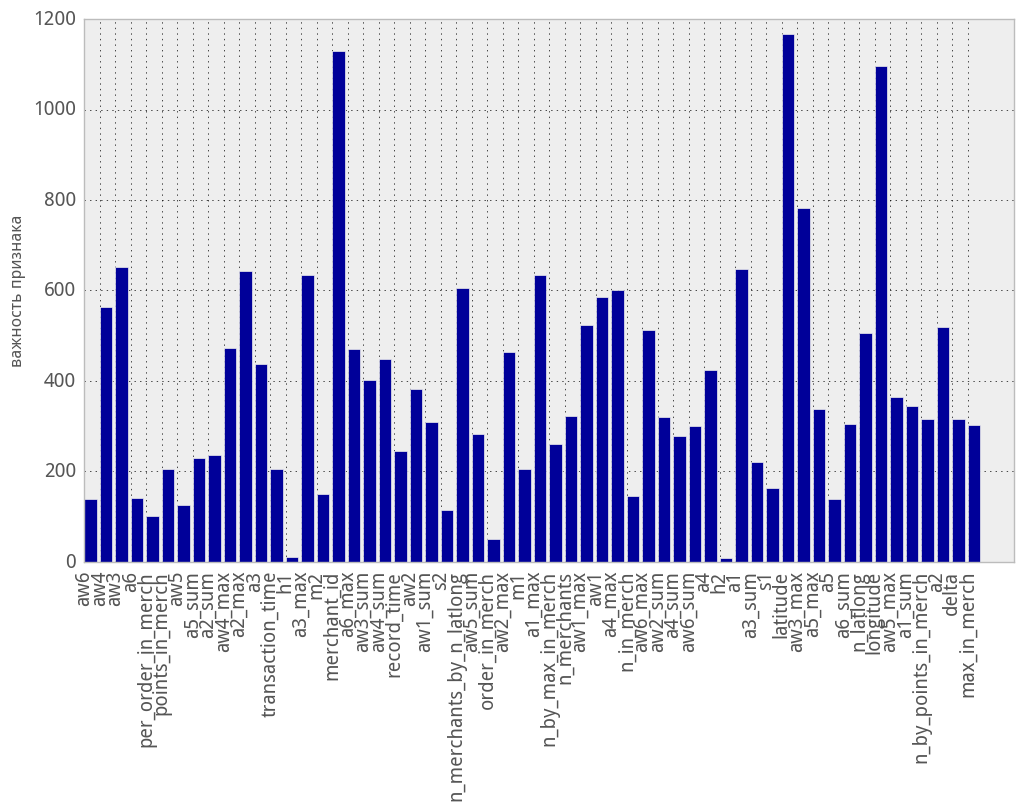

In [56]:
figsize(12, 7)
imp = clf.booster().get_fscore()
# imp = dict(sorted(imp.items(), key=lambda x: -x[1]))
v = imp.values()
k = imp.keys()
#imp.values()
plt.bar(np.arange(len(v)), v, color='#000099')
plt.xticks(np.arange(len(v)), k, rotation=90)
plt.ylabel(u'важность признака')
plt.show()

In [53]:
# отсортированные важности признаков
sorted(imp.items(), key=lambda x: -x[1])

[('latitude', 1168),
 ('merchant_id', 1129),
 ('longitude', 1096),
 ('aw3_max', 783),
 ('aw3', 651),
 ('a1', 648),
 ('a2_max', 642),
 ('a3_max', 635),
 ('a1_max', 635),
 ('n_merchants_by_n_latlong', 605),
 ('a4_max', 602),
 ('aw1', 585),
 ('aw4', 564),
 ('aw1_max', 524),
 ('a2', 519),
 ('aw6_max', 512),
 ('n_latlong', 505),
 ('aw4_max', 473),
 ('a6_max', 470),
 ('aw2_max', 464),
 ('aw4_sum', 448),
 ('a3', 438),
 ('a4', 424),
 ('aw3_sum', 401),
 ('aw2', 382),
 ('aw5_max', 364),
 ('a1_sum', 344),
 ('a5_max', 338),
 ('n_merchants', 323),
 ('aw2_sum', 319),
 ('delta', 316),
 ('n_by_points_in_merch', 315),
 ('aw1_sum', 310),
 ('a6_sum', 304),
 ('max_in_merch', 303),
 ('aw6_sum', 301),
 ('aw5_sum', 283),
 ('a4_sum', 277),
 ('n_by_max_in_merch', 261),
 ('record_time', 245),
 ('a2_sum', 237),
 ('a5_sum', 229),
 ('a3_sum', 220),
 ('transaction_time', 205),
 ('points_in_merch', 204),
 ('m1', 204),
 ('s1', 163),
 ('m2', 149),
 ('n_in_merch', 146),
 ('a6', 140),
 ('aw6', 138),
 ('a5', 138),
 ('aw5

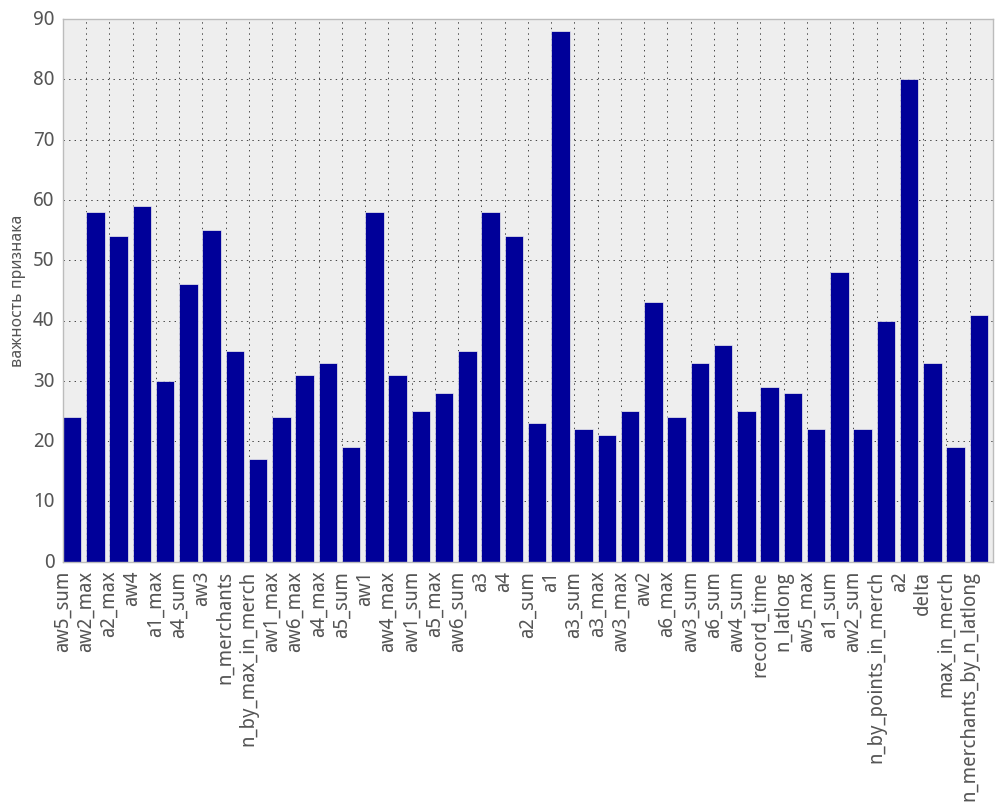

In [74]:
clf.fit(X.drop(del_feat, axis=1), y)
figsize(12, 7)
imp = clf.booster().get_fscore()
# imp = dict(sorted(imp.items(), key=lambda x: -x[1]))
v = imp.values()
k = imp.keys()
#imp.values()
plt.bar(np.arange(len(v)), v, color='#000099')
plt.xticks(np.arange(len(v)), k, rotation=90)
plt.ylabel(u'важность признака')
plt.show()

In [107]:
a = cvp[:, 1]


X2b = X.copy() # X1 !!!
X2b['a'] = a # X2.iloc[:, -4]
train_tmp = train.sort('merchant_id')
tmp = X2b.groupby(['merchant_id'])
aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
aa = aa.sort('merchant_id')

#print (test_X.shape, aa.shape, train_X.shape,)

print ('Точность до настройки = ' + str(myerror(train_tmp, aa)))

for user in aa.merchant_id:
    tmp = transactions[transactions.merchant_id == user]
    tmp = tmp.drop_duplicates('fd') # !!!
    lats = tmp.latitude.values
    longs = tmp.longitude.values
    tmp0 = aa[aa.merchant_id == user]
    ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.006
    x_a = np.mean(lats[ii])
    y_a = np.mean(longs[ii])
    aa.loc[aa.merchant_id == user, 'latitude'] = x_a
    aa.loc[aa.merchant_id == user, 'longitude'] = y_a
    
print ('Точность после настройки = ' + str(myerror(train_tmp, aa)))
# Точность до настройки = 0.357142857143
# Точность после настройки = 0.369793273681

Точность до настройки = 0.346497994446
Точность после настройки = 0.359765504474


In [101]:
a = cvp[:, 1]


X2b = X.copy() # X1 !!!
X2b['a'] = a # X2.iloc[:, -4]
X2b['fd'] = X2b.latitude.astype(str) + ' ' + X2b.longitude.astype(str)
train_tmp = train.sort('merchant_id')
tmp = X2b.groupby(['merchant_id'])
aa = X2b.loc[tmp['a'].idxmax(), :][['merchant_id', 'latitude', 'longitude']]
aa = aa.sort('merchant_id')

#print (test_X.shape, aa.shape, train_X.shape,)

print ('Точность до настройки = ' + str(myerror(train_tmp, aa)))

for user in aa.merchant_id:
    tmp = X2b[X2b.merchant_id == user]
    tmp = tmp.drop_duplicates('fd') # !!!
    lats = tmp.latitude.values
    longs = tmp.longitude.values
    tmp0 = aa[aa.merchant_id == user]
    ii = np.sqrt((lats - tmp0.latitude.values[0]) ** 2 + (longs - tmp0.longitude.values[0]) ** 2) <= 0.005
    x_a = lats[ii]
    y_a = longs[ii]
    w_a = tmp.a.values[ii]
    aa.loc[aa.merchant_id == user, 'latitude'] = np.dot(x_a, w_a)/np.sum(w_a)
    aa.loc[aa.merchant_id == user, 'longitude'] = np.dot(y_a, w_a)/np.sum(w_a)
    
aa.loc[aa.latitude < 0.1, 'latitude'] = 55.740213
aa.loc[aa.longitude < 0.1, 'longitude'] =  37.656371
    
print ('Точность после настройки = ' + str(myerror(train_tmp, aa)))

#Точность до настройки = 0.357142857143
#Точность после настройки = 0.372878741129 -> 0.373187287874


Точность до настройки = 0.357142857143
Точность после настройки = 0.373187287874
